# Genetic Algorithm NeuroEvolution
Evolving the weights of a fixed Neural Controller using Genetic Algorithm

In [76]:
import importlib
import environment 
import neural_controller
importlib.reload(environment)
importlib.reload(neural_controller)

import numpy as np
import time
import random

In [77]:
initial_setting = {
    'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
    'blocks': np.array([[9, 16], [13, 7], [6, 5], [10, 11]], dtype=float),
    'colors': np.array([environment.RED, environment.RED, environment.BLUE, environment.GREEN], dtype=int)
}
env = environment.Environment(objective = [(environment.RED, environment.NORTH_EDGE)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 3, 
                   n_blocks = 4,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_distance_covered_per_step = environment.SIMULATION_MAX_DISTANCE,
                   sensitivity = 0.5,
                   initial_setting = initial_setting)
env.reset()
env.print_env()

. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . O . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . O . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . O . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .


In [78]:
input_dim = (env.n_types + 2) * env.n_neighbors + env.n_types - 2
output_dim = 2
hidden_units = [32]
layer_sizes = [input_dim] + hidden_units + [output_dim]

nn = neural_controller.NeuralController(layer_sizes, hidden_activation="sigmoid", output_activation="sigmoid")
nn.summary()

NeuralController with layer sizes:  [44, 32, 2]
Total weights: 1506, not set


In [79]:
def select_parents(population, fitnesses, n_parents, tournament_size=5):
    def tournament():
        # Randomly select tournament_size individuals from the population
        participants = np.random.randint(len(population), size=tournament_size)
        # Select the participant with the maximum fitness
        winner_index = participants[np.argmax(fitnesses[participants])]
        return population[winner_index]

    # List to hold all selected parents
    parents = []
    # Generate n pairs of parents
    for _ in range(n_parents):
        parent1 = tournament()
        parent2 = tournament()
        # Ensure we get two different parents for diversity 
        while np.array_equal(parent1, parent2):
            parent2 = tournament()
        parents.append((parent1, parent2))
    
    return parents

def crossover(parents):
    offspring = []
    for parent1, parent2 in parents:
        crossover_point = np.random.randint(len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
    return offspring

def mutate(offspring, mutation_rate=0.1):
    for child in offspring:
        if np.random.rand() < mutation_rate:
            random_gene = np.random.randint(0, 2)
            child[random_gene] += np.clip(np.random.normal(), -3, 3)
    return offspring

In [80]:
def calculate_fitnesses(population : np.ndarray, 
                        network : neural_controller.NeuralController,
                        env : environment.Environment, 
                        n_steps=100,
                        verbose=False):
    
    fitnesses = np.zeros(len(population))
    flag_done = False
    best_steps = n_steps
    
    for genome_id, genome in enumerate(population):

        fitnesses[genome_id] = 0
        obs, _ = env.reset()
        
        # Set the weights of the network
        network.set_weights_from_vector(genome)

        for step in range(n_steps):
            
            nn_inputs = env.process_observation(obs)
            nn_outputs = np.array(network.predict(nn_inputs))
            actions = np.round(nn_outputs * np.array([env.max_distance_covered_per_step, env.sensor_angle]), 1)
                
            obs, reward, done, _, _ = env.step(actions)
            
            fitnesses[genome_id] += reward

            if verbose:
                print("\nStep", step)
                # print("Observation: ", obs)
                # print("NN inputs: ", nn_inputs)
                print("Action: ", actions)
                env.print_env()
                print("Reward: ", reward)
            
            if done:
                fitnesses[genome_id] += (n_steps - step) / 2
                flag_done = True
                if best_steps > step:
                    best_steps = step
                break
        
    if flag_done:
        print(f"Done in {best_steps} steps")
    
    return fitnesses

In [84]:
pop_size = 100
num_generations = 50
num_elite = int(0.05 * pop_size) # 5% of the population will be copied to the next generation (elitism)
num_removed = int(0.1 * pop_size) # 10% of the population will be removed and randomly replaced
tournament_size = int(0.03 * pop_size)
offspring_size = pop_size - num_elite - num_removed

population = np.random.normal(0, 1, (pop_size, nn.total_weights))
population.shape

(100, 1506)

In [85]:
stats = []

patience = 0
for generation in range(num_generations):
    print(f"Generation {generation}")
    start_gen = time.time()

    fitnesses = calculate_fitnesses(population, nn, env, n_steps=100)

    elite = population[np.argsort(fitnesses)][-num_elite:].copy()

    replacements = np.random.normal(0, 1, (num_removed, nn.total_weights))
    
    parents = select_parents(population, fitnesses, offspring_size, tournament_size)
    
    offspring = crossover(parents)

    offspring = mutate(offspring)
    
    population = np.concatenate((elite, offspring, replacements), axis=0)

    end_gen = time.time()

    avg_fitness = np.mean(fitnesses)
    best_fitness = np.max(fitnesses)
    std_fitness = np.std(fitnesses)  
    stats.append((best_fitness, avg_fitness, std_fitness)) 
    print(f"Time taken: {round(end_gen- start_gen, 2)}")
    print(f"Best = {round(best_fitness, 2)}, Average = {round(avg_fitness, 2)}, Std = {round(std_fitness, 2)}\n")

    # # Early stopping
    # if generation > 5:
    #     if best_fitness - stats[-2][0] < 0.1:
    #         patience += 1
    #         if patience > 20:
    #             print(f"Early stopping - no improvement in fitness ({best_fitness}).")
    #             break
    #     else:
    #         patience = 0

best_genome = population[np.argmax(fitnesses)]
worst_genome = population[np.argmin(fitnesses)]

Generation 0
Time taken: 7.84
Best = 0.08, Average = -72.54, Std = 202.32

Generation 1
Time taken: 6.96
Best = 0.08, Average = -20.16, Std = 106.37

Generation 2
Time taken: 6.99
Best = 6.71, Average = -28.02, Std = 133.26

Generation 3
Time taken: 7.6
Best = 9.41, Average = -11.94, Std = 72.33

Generation 4
Time taken: 7.0
Best = 9.41, Average = -7.84, Std = 47.53

Generation 5
Time taken: 7.19
Best = 9.41, Average = -17.62, Std = 87.64

Generation 6
Time taken: 7.28
Best = 20.03, Average = -24.68, Std = 109.81

Generation 7
Time taken: 7.23
Best = 20.03, Average = -20.09, Std = 103.07

Generation 8
Time taken: 7.33
Best = 20.03, Average = -7.15, Std = 47.47

Generation 9
Time taken: 7.28
Best = 20.03, Average = -11.53, Std = 67.16

Generation 10
Time taken: 7.24
Best = 20.23, Average = -9.2, Std = 69.42

Generation 11
Time taken: 7.33
Best = 20.23, Average = 1.02, Std = 5.62

Generation 12
Time taken: 7.53
Best = 20.23, Average = -13.69, Std = 82.53

Generation 13
Time taken: 7.56
B

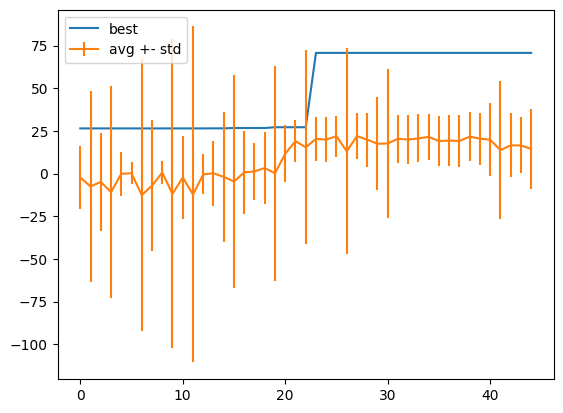

In [72]:
# Plotting the stats
import matplotlib.pyplot as plt

# Plotting
bests, avgs, stds = zip(*stats)
x_values = np.arange(len(np.array(avgs))) # X-axis values (assuming one data point per unit)
plt.plot(bests, label="best")
plt.errorbar(x_values, avgs, yerr=stds, label='avg +- std')
# plt.plot(avg, label="Average")
# plt.plot(std, label="Std")
plt.legend()
plt.show()

In [86]:
calculate_fitnesses([best_genome], nn, env, n_steps=100, verbose=True)


Step 0
Action:  [[ 0.8 19.6]
 [ 0.8 19.6]
 [ 0.8 19.6]]
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . 0 . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . O . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . O . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . O . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . .

array([26.77875122])